# Análise Exploratória de Dados - Olist Customer Reviews

Este notebook tem como objetivo realizar uma análise exploratória sobre o dataset de avaliações de clientes da Olist. O foco é entender a distribuição dos dados, a qualidade dos textos e extrair insights que guiarão a preparação dos dados e a modelagem para o problema de análise de sentimento.

## 1. Carregando Bibliotecas e Dados

In [2]:
!pip install seaborn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

# Adiciona o diretório 'src' ao path para importar módulos do projeto
sys.path.append('../')

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# O dataset deve estar na pasta /data no mesmo nível da pasta /eda
DATA_PATH = '../data/olist_order_reviews_dataset.csv'

try:
    df_reviews = pd.read_csv(DATA_PATH)
    print("Dataset carregado com sucesso!")
    print(f"Shape do dataset: {df_reviews.shape}")
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em '{DATA_PATH}'. Certifique-se de que o dataset está no local correto.")

df_reviews.head()

Dataset carregado com sucesso!
Shape do dataset: (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## 2. Análise da Distribuição das Notas (`review_score`)

A primeira e mais importante análise para um problema de classificação de sentimento é entender a distribuição da nossa variável-alvo, que neste caso é a nota (`review_score`).

/var/folders/0_/5nl6yw7x4jqglhtkrzqs5vv40000gn/T/ipykernel_49351/3260088713.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=score_counts.index, y=score_counts.values, palette='viridis')


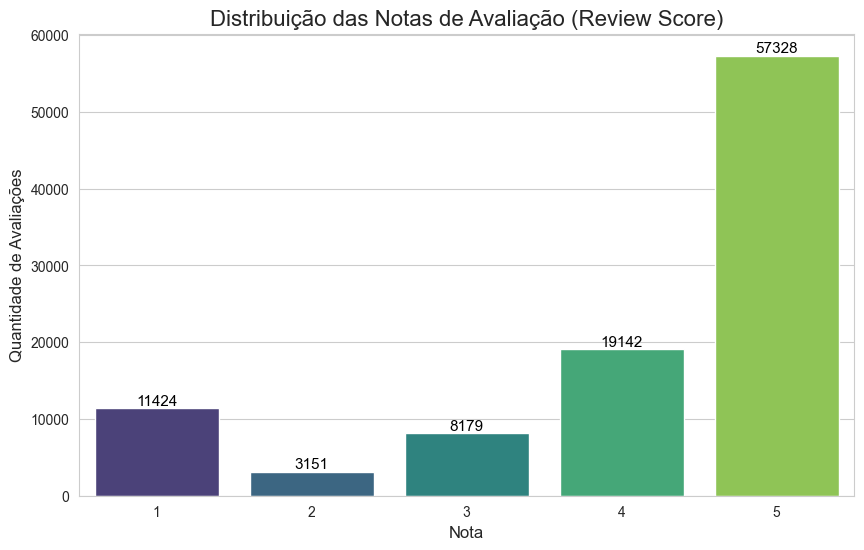

In [5]:
score_counts = df_reviews['review_score'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=score_counts.index, y=score_counts.values, palette='viridis')

plt.title('Distribuição das Notas de Avaliação (Review Score)', fontsize=16)
plt.xlabel('Nota', fontsize=12)
plt.ylabel('Quantidade de Avaliações', fontsize=12)
plt.xticks(ticks=np.arange(5), labels=[1, 2, 3, 4, 5])

# Adicionando os valores em cima das barras
for i in ax.containers:
    ax.bar_label(i, fmt='%d', fontsize=11, color='black')

plt.show()

### Conclusão da Análise de Distribuição

**"Analisei a distribuição das notas (1 a 5). Percebi um desbalanceamento: há muito mais clientes satisfeitos do que insatisfeitos."**

O gráfico confirma essa observação de forma clara. As notas 4 e 5, que representam clientes satisfeitos, somam a esmagadora maioria das avaliações. Por outro lado, as notas 1 e 2 (clientes insatisfeitos) são significativamente menos frequentes.

**Implicações para o Projeto:**
1.  **Desbalanceamento de Classes:** Este é um clássico problema de classes desbalanceadas. Se não for tratado, o modelo de Machine Learning pode desenvolver um viés, aprendendo a prever majoritariamente a classe positiva ("Satisfeito") e ignorando a classe negativa, que muitas vezes é a mais importante do ponto de vista de negócio.
2.  **Definição do Target:** Para criar um classificador binário (Satisfeito vs. Insatisfeito), e agrupar (1, 2) como `INSATISFEITO` e (3, 4, 5) como `SATISFEITO`.
3.  **Métricas de Avaliação:** A acurácia não será uma boa métrica. Devemos focar em métricas como **Precision, Recall e F1-Score**, que são mais robustas para datasets desbalanceados.

## 3. Análise dos Comentários (`review_comment_message`)

Para um modelo de NLP, é fundamental que tenhamos texto para analisar. Vamos verificar a quantidade de avaliações que de fato possuem um comentário.

In [6]:
total_reviews = len(df_reviews)
reviews_with_comment = df_reviews['review_comment_message'].notna().sum()
reviews_without_comment = total_reviews - reviews_with_comment

print(f"Total de avaliações: {total_reviews}")
print(f"Avaliações COM comentário: {reviews_with_comment} ({reviews_with_comment/total_reviews:.2%})")
print(f"Avaliações SEM comentário: {reviews_without_comment} ({reviews_without_comment/total_reviews:.2%})")

# Para o nosso projeto, usaremos apenas as avaliações que contêm texto.
df_com_texto = df_reviews.dropna(subset=['review_comment_message']).copy()

Total de avaliações: 99224
Avaliações COM comentário: 40977 (41.30%)
Avaliações SEM comentário: 58247 (58.70%)


## 4. Nuvem de Palavras por Sentimento

Uma nuvem de palavras (Word Cloud) é uma ótima forma de visualizar rapidamente os termos mais frequentes em um corpo de texto. Vamos criar uma para reviews positivos e outra para negativos para ver se já conseguimos identificar padrões.

Primeiro, precisamos instalar a biblioteca `wordcloud`.

In [7]:
!pip install wordcloud

In [8]:
from wordcloud import WordCloud, STOPWORDS
from src.etl.processor import clean_text # Reutilizando a função de limpeza do projeto

# Definindo stopwords em português
stopwords_pt = set(STOPWORDS)
stopwords_pt.update(["que", "pra", "para", "de", "do", "da", "em", "um", "uma", "foi", "e", "o", "a", "meu", "minha", "com", "na", "no", "mas", "eu", "ele", "ela", "sao", "muito", "mais", "foi", "chegou", "produto", "compra", "pedido", "loja", "vendedor", "recebi", "veio", "ainda", "gostei", "bem", "antes", "depois", "dia", "data", "tudo", "so", "nao"])

# Separando textos por sentimento
df_com_texto['sentimento'] = df_com_texto['review_score'].apply(lambda x: 'positivo' if x > 3 else ('negativo' if x < 3 else 'neutro'))

texto_positivo = ' '.join(review for review in df_com_texto[df_com_texto['sentimento'] == 'positivo']['review_comment_message'])
texto_negativo = ' '.join(review for review in df_com_texto[df_com_texto['sentimento'] == 'negativo']['review_comment_message'])

# Limpando os textos
texto_positivo_limpo = clean_text(texto_positivo)
texto_negativo_limpo = clean_text(texto_negativo)

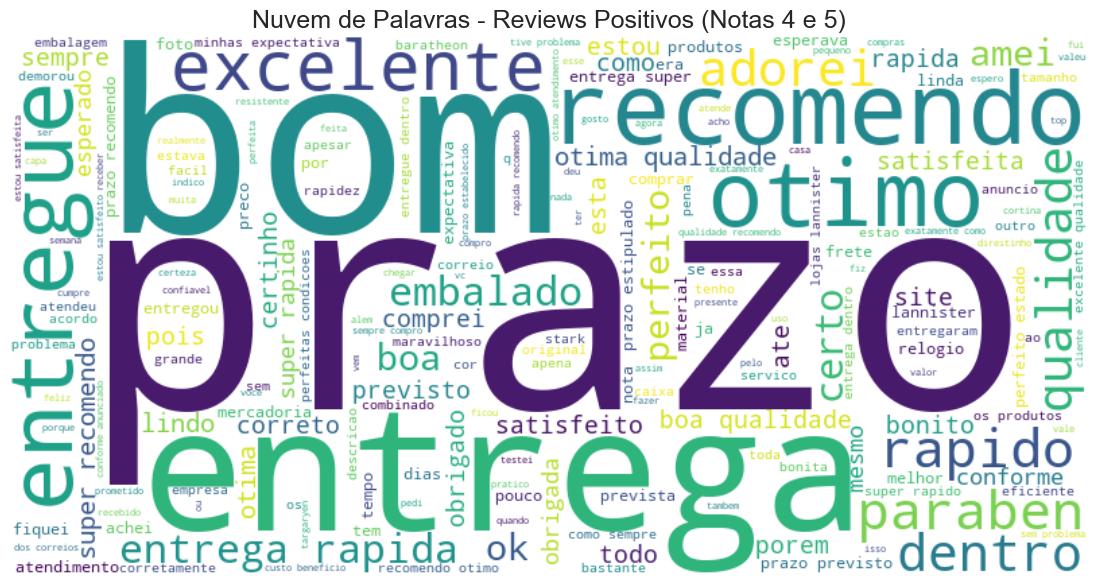

In [9]:
# Gerando a nuvem de palavras para reviews POSITIVOS
wordcloud_pos = WordCloud(stopwords=stopwords_pt, background_color="white", width=800, height=400).generate(texto_positivo_limpo)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Nuvem de Palavras - Reviews Positivos (Notas 4 e 5)", fontsize=18)
plt.axis("off")
plt.show()

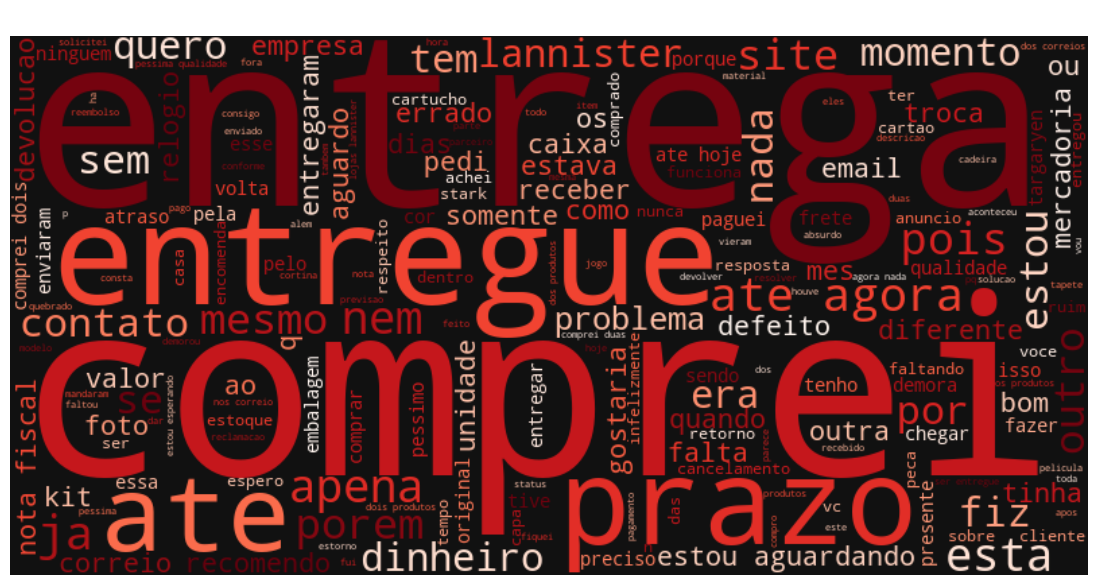

In [10]:
# Gerando a nuvem de palavras para reviews NEGATIVOS
wordcloud_neg = WordCloud(stopwords=stopwords_pt, background_color="#111111", colormap='Reds', width=800, height=400).generate(texto_negativo_limpo)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Nuvem de Palavras - Reviews Negativos (Notas 1 e 2)", fontsize=18, color='white')
plt.axis("off")
plt.show()

### Conclusão da Análise das Nuvens de Palavras

As nuvens de palavras nos dão uma visão qualitativa interessante:

- **Reviews Positivos:** Palavras como "otimo", "bom", "rapido", "perfeito", "recomendo", "parabens" são dominantes. Elas indicam satisfação com a qualidade do produto e a velocidade da entrega.
- **Reviews Negativos:** Termos como "demorou", "errado", "cancelado", "problema", "defeito", "entrega" se destacam. Isso sugere que a maior parte da insatisfação está relacionada a problemas logísticos (atraso, produto errado) ou defeitos no item recebido.

Essa análise inicial já fornece pistas valiosas sobre os principais motivadores de satisfação e insatisfação dos clientes.